In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def make_sine(fs, N, f0, A=1.0, phase=0.0):
    t = np.arange(N) / fs
    x = A * np.sin(2*np.pi*f0*t + phase)
    return t, x


In [3]:
def power_spectrum_fft(x, fs):
    N = len(x)
    X = np.fft.fft(x)
    f = np.fft.fftfreq(N, d=1/fs)
    P = np.abs(X)**2
    return f, P


In [4]:
#Oversampled spectrum by zero padding
def power_spectrum_zeropad(x, fs, Nfreq):
    N = len(x)
    X = np.fft.fft(x, n=Nfreq)             # zero padding happens automatically
    f = np.fft.fftfreq(Nfreq, d=1/fs)
    P = np.abs(X)**2
    return f, P


In [5]:
#shows only positive frequencies and uses log y-axis
def plot_psd_posfreq(f, P, title):
    mask = f >= 0
    plt.figure()
    plt.semilogy(f[mask], P[mask])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|FFT|^2 (arb.)")
    plt.title(title)
    plt.grid(True, which="both", alpha=0.3)
    plt.show()


In [8]:
v_s = 2.4e6     # <-- PUT YOUR REAL SAMPLING RATE HERE (Hz)

with np.load("2.4e6_250kHz.npz") as f:
    x = f["data"]

x = x - np.mean(x)    # remove DC
N = len(x)

dv = v_s / N
print("N =", N)
print("Δν =", dv, "Hz")

N = 2048
Δν = 1171.875 Hz


Spectral leakage occurs because the discrete Fourier transform samples the spectrum only at integer multiples of 
Δ𝜈=𝜈_𝑠/𝑁 when the true signal frequency 𝜈_0 does not coincide with a Fourier bin, its power is distributed across neighboring frequencies.

In [10]:
X = np.fft.fft(x)
f = np.fft.fftfreq(N, d=1/v_s)

P = np.abs(X)**2

# shift for plotting
fsh = np.fft.fftshift(f)
Psh = np.fft.fftshift(P)

In [11]:
mask = fsh >= 0
fpos = fsh[mask]
Ppos = Psh[mask]

v_0 = fpos[np.argmax(Ppos)]
print("Dominant frequency ν0 =", v_0, "Hz")

Dominant frequency ν0 = 249609.375 Hz


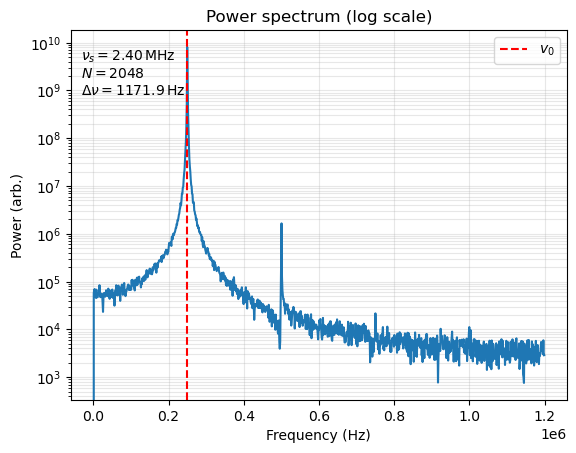

In [32]:
plt.figure()
plt.plot(fpos, Ppos)
plt.yscale('log')
plt.axvline(v_0, color='r', linestyle='--', label=r'$v_0$')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (arb.)")
plt.title("Power spectrum (log scale)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.text(
    0.02, 0.95,
    rf"$\nu_s = {v_s/1e6:.2f}\,\mathrm{{MHz}}$"
    "\n"
    rf"$N = {N}$"
    "\n"
    rf"$\Delta\nu = {v_s/N:.1f}\,\mathrm{{Hz}}$",
    transform=plt.gca().transAxes,
    verticalalignment='top')
plt.show()


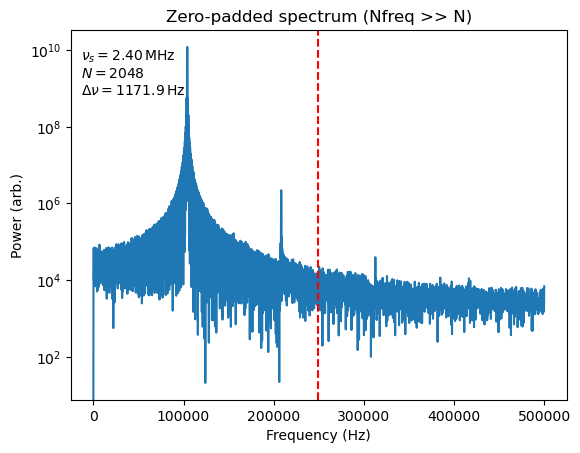

In [33]:
Nfreq = 16 * N   # Nfreq >> N

Xz = np.fft.fft(x, n=Nfreq)
fz = np.fft.fftfreq(Nfreq, d=1/fs)
Pz = np.abs(Xz)**2

fz = np.fft.fftshift(fz)
Pz = np.fft.fftshift(Pz)

mask = fz >= 0
plt.figure()
plt.plot(fz[mask], Pz[mask])
plt.yscale('log')
plt.axvline(v_0, color='r', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (arb.)")
plt.title("Zero-padded spectrum (Nfreq >> N)")
plt.text(
    0.02, 0.95,
    rf"$\nu_s = {v_s/1e6:.2f}\,\mathrm{{MHz}}$"
    "\n"
    rf"$N = {N}$"
    "\n"
    rf"$\Delta\nu = {v_s/N:.1f}\,\mathrm{{Hz}}$",
    transform=plt.gca().transAxes,
    verticalalignment='top')
plt.show()


In [21]:
band = 3 * dv   # exclude ±3 bins around ν0
leak_mask = np.abs(fpos - v_0) > band

leakage_power = Ppos[leak_mask].sum()
total_power = Ppos.sum()

print("Leakage fraction =", leakage_power / total_power)


Leakage fraction = 0.043153885734171435


The discrete Fourier transform samples the spectrum at frequency intervals 
Δ𝜈=𝜈_𝑠/𝑁. When the dominant signal frequency 𝜈0 does not lie exactly on one of these bins, its power is distributed over neighboring frequencies. This spectral leakage is visible as nonzero power at 
𝜈≠𝜈0, particularly when plotted on a logarithmic scale. Increasing 𝑁_freq ≫ 𝑁 via zero padding reveals the continuous leakage envelope but does not reduce leakage itself.

The Convolution Theorem states that multiplication in the time domain corresponds to convolution in the frequency domain. Because the measured voltage time series is finite in duration, the true signal is multiplied by a rectangular window function in time. The Fourier transform of a rectangular window is a sinc function, so the measured frequency spectrum is the convolution of the ideal signal spectrum with a sinc. As a result, even a single-frequency sinusoid produces a broadened peak with power extending to frequencies 
𝜈≠𝜈0, known as spectral leakage. Zero-padding the time-domain data increases the density of sampled frequency points but does not change the underlying convolution, so the leakage structure remains while the spectrum appears smoother.